### Prophet

- 페이스북에서 시계열 데이터를 다루기 위해 만든 라이브러리

- 통계적인 지식 없이 시계열 데이터를 기반으로 자동으로 예측 수행해줌

  (ARIMA 모델과 같은 고급 시계열 분석 지식 없이도 간단하게 시계열 데이터를 예측 가능)

- 아웃라이어나 노이즈에 강건한 편이며 학습 속도가 빠름

[주요 기능]

- 계절 변동성, 휴일, 회귀요소를 포함하여 예측 진행 가능

- 불확실성 구간을 판단하여 예측치에 포함하여 출력

- 모델에 대한 cross-validation이나 파라미터 튜닝 지원

- 아웃라이어 처리(자동으로 interpolation수행하여 아웃라이어 다룰 수 있게 함)

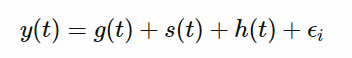

- g(t) : 주기적이지 않은 변화인 트렌드 나타냄

- s(t) : weekly, yearly 등 주기적으로 나타나는 패턴을 포함

- h(t) : 휴일과 같이 불규칙한 이벤트 패턴 포함

- ϵ_i : 정규분포라고 가정한 오차

https://slowsteadystat.tistory.com/7

https://forecastegy.com/posts/multiple-time-series-forecasting-with-prophet-in-python/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/train.csv')

In [ ]:
train.shape

(3000888, 6)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [ ]:
# date 컬럼 datetime 형식으로 변환
train['date'] = pd.to_datetime(train['date'])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [ ]:
# 결측치 확인
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [ ]:
train.head(10)

id       date  store_nbr        family  sales  onpromotion
0   0 2013-01-01          1    AUTOMOTIVE    0.0            0
1   1 2013-01-01          1     BABY CARE    0.0            0
2   2 2013-01-01          1        BEAUTY    0.0            0
3   3 2013-01-01          1     BEVERAGES    0.0            0
4   4 2013-01-01          1         BOOKS    0.0            0
5   5 2013-01-01          1  BREAD/BAKERY    0.0            0
6   6 2013-01-01          1   CELEBRATION    0.0            0
7   7 2013-01-01          1      CLEANING    0.0            0
8   8 2013-01-01          1         DAIRY    0.0            0
9   9 2013-01-01          1          DELI    0.0            0

In [ ]:
train.tail(10)

id       date  store_nbr                      family     sales  \
3000878  3000878 2017-08-15          9                   MAGAZINES    11.000   
3000879  3000879 2017-08-15          9                       MEATS   449.228   
3000880  3000880 2017-08-15          9               PERSONAL CARE   522.000   
3000881  3000881 2017-08-15          9                PET SUPPLIES     6.000   
3000882  3000882 2017-08-15          9     PLAYERS AND ELECTRONICS     6.000   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
3000878            0  
3000879            0  
3000880           11  
3000881            0  
3000882            0  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0

In [ ]:
# train 데이터에서 가장 이른 날짜와 가장 늦은 날짜 확인
earliest_date = train['date'].min()
latest_date = train['date'].max()

# 모든 날짜가 포함되어 있는지 확인
all_dates = pd.date_range(start=earliest_date, end=latest_date)
missing_dates = all_dates[~all_dates.isin(train['date'])]

print("빠져 있는 날짜:", missing_dates)

빠져 있는 날짜: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


매년 크리스마스가 빠져있음

크리스마스와 같은 중요한 휴일이 매년 빠져 있는데, 해당 날짜의 데이터가 누락되었음을 나타낼 수 있도록 모든 열을 NaN으로 채워봄

In [ ]:
# 12월 25일에 해당하는 행 생성
missing_christmas = pd.DataFrame({'date': pd.date_range(start='2013-12-25', end='2017-01-01', freq='Y'),
                                  'store_nbr': pd.NA, 'family': pd.NA, 'sales': pd.NA, 'onpromotion': pd.NA})

# 기존 train 데이터에 추가
train = pd.concat([train, missing_christmas], ignore_index=True).sort_values('date')

In [ ]:
train.isnull().sum()

id             4
date           0
store_nbr      4
family         4
sales          4
onpromotion    4
dtype: int64

In [ ]:
# train/validation 데이터 split
train_data = train[train['date'] < '2017-08-01']
validation_data = train[train['date'] >= '2017-08-01']

In [ ]:
train_data.shape

(2974162, 6)

In [ ]:
validation_data.shape

(26730, 6)

In [ ]:
validation_data.head()

id       date store_nbr                      family     sales  \
2975344  2975344.0 2017-08-01        41  SCHOOL AND OFFICE SUPPLIES     0.000   
2975352  2975352.0 2017-08-01        42                 CELEBRATION     8.000   
2975351  2975351.0 2017-08-01        42                BREAD/BAKERY   643.267   
2975350  2975350.0 2017-08-01        42                       BOOKS     0.000   
2975349  2975349.0 2017-08-01        42                   BEVERAGES  5818.000   

        onpromotion  
2975344           0  
2975352           0  
2975351           0  
2975350           0  
2975349          20

In [ ]:
validation_data.tail()

id       date store_nbr                   family    sales  \
2999695  2999695.0 2017-08-15        25                  POULTRY  172.517   
2999694  2999694.0 2017-08-15        25  PLAYERS AND ELECTRONICS    3.000   
2999693  2999693.0 2017-08-15        25             PET SUPPLIES    3.000   
2999704  2999704.0 2017-08-15        26                    BOOKS    0.000   
2999554  2999554.0 2017-08-15        21               LADIESWEAR    5.000   

        onpromotion  
2999695           0  
2999694           0  
2999693           0  
2999704           0  
2999554           0

In [ ]:
## prophet 모델 훈련
from prophet import Prophet

# Prophet 모델 생성
model = Prophet(seasonality_mode='additive', yearly_seasonality=True,
                weekly_seasonality=True, daily_seasonality=False)

# 'ds'와 'y' 열로 데이터프레임 생성
train_df = train_data[['date', 'sales']].copy()
train_df.columns = ['ds', 'y']

# Prophet 모델에 데이터 추가
model.fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp46fnqfcd/4eivz4wh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46fnqfcd/ldckedc6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59930', 'data', 'file=/tmp/tmp46fnqfcd/4eivz4wh.json', 'init=/tmp/tmp46fnqfcd/ldckedc6.json', 'output', 'file=/tmp/tmp46fnqfcd/prophet_model9vw7yo5y/prophet_model-20240507173906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# validation 데이터에서 'date'와 'sales' 열 선택
val_df = validation_data[['date', 'sales']].copy()

# 'date' 열을 'ds'로, 'sales' 열을 'y'로 변경
val_df.columns = ['ds', 'y']

In [ ]:
validation_grouped = validation_data.groupby('date')['sales'].mean()
validation_grouped

date
2017-08-01    554.729385
2017-08-02    541.364768
2017-08-03    408.568173
2017-08-04    464.520587
2017-08-05    541.915629
2017-08-06    588.978207
2017-08-07    447.511203
2017-08-08    402.786952
2017-08-09    411.975126
2017-08-10    365.536988
2017-08-11    463.733851
2017-08-12    444.798280
2017-08-13    485.768618
2017-08-14    427.004717
2017-08-15    427.980884
Name: sales, dtype: float64

In [ ]:
from datetime import datetime

# validation 데이터에 대한 예측 수행
# start_date = datetime(2017, 1, 1)
# end_date = datetime(2017, 8, 15)
# num_days = (end_date - start_date).days + 1
future = model.make_future_dataframe(periods=15)
forecast = model.predict(future)

# 예측 결과 출력
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15))

# 예측 값과 실제 값 사이의 오차 계산
from sklearn.metrics import mean_squared_error

# 실제 값과 예측 값 추출
y_true = validation_grouped.values
y_pred = forecast['yhat'].values[-15:]

# 평균 제곱 오차 계산
mse = mean_squared_error(y_true, y_pred)
print('Mean Squared Error:', mse)

             ds        yhat   yhat_lower   yhat_upper
1669 2017-08-01  437.542371  -961.046917  1754.040954
1670 2017-08-02  448.753210 -1039.621030  1862.050259
1671 2017-08-03  397.564969  -965.009200  1850.328378
1672 2017-08-04  437.103724  -947.061115  1909.816040
1673 2017-08-05  543.051599  -885.051942  2013.251022
1674 2017-08-06  571.685430  -921.779884  1969.678394
1675 2017-08-07  452.534700 -1008.268621  1815.950293
1676 2017-08-08  424.463628  -959.734048  1797.022579
1677 2017-08-09  437.195804 -1076.883072  1786.199605
1678 2017-08-10  387.759422  -959.147728  1769.962081
1679 2017-08-11  429.251497  -947.114816  1767.718273
1680 2017-08-12  537.320366  -835.179295  1934.240193
1681 2017-08-13  568.205097  -841.912775  1972.607093
1682 2017-08-14  451.394279  -907.877271  1930.357776
1683 2017-08-15  425.709068 -1124.726905  1862.409442
Mean Squared Error: 2816.864603654201


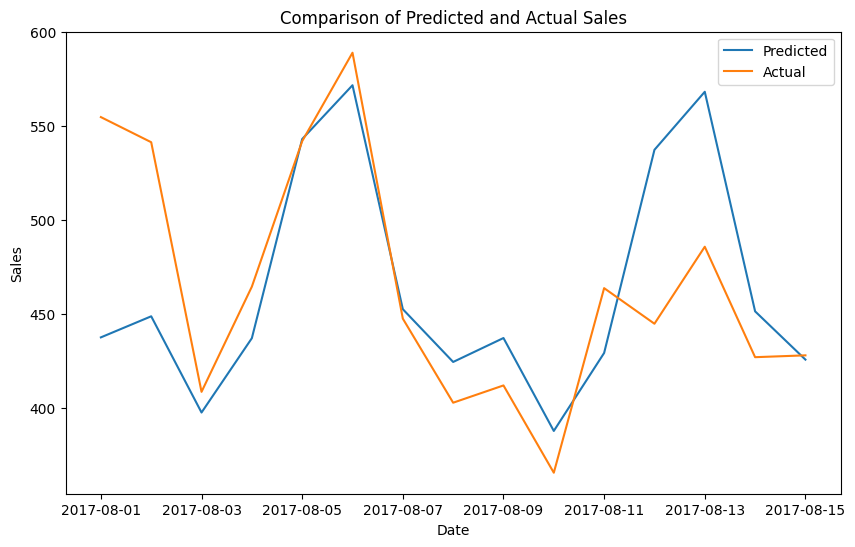

In [ ]:
# 시각화를 위해 예측값과 실제값을 DataFrame으로 변환
forecast_df = forecast[['ds', 'yhat']].tail(15)
forecast_df['date'] = forecast_df['ds'].dt.date
forecast_df = forecast_df.set_index('date')

# 실제값에 대한 DataFrame 생성
validation_df = validation_data.groupby('date')['sales'].mean().reset_index()
validation_df = validation_df.set_index('date')

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(forecast_df.index, forecast_df['yhat'], label='Predicted')
plt.plot(validation_df.index, validation_df['sales'], label='Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Comparison of Predicted and Actual Sales')
plt.legend()
plt.show()

In [ ]:
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/test.csv')
test.head()

id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0

In [ ]:
test.tail()

id        date  store_nbr                      family  \
28507  3029395  2017-08-31          9                     POULTRY   
28508  3029396  2017-08-31          9              PREPARED FOODS   
28509  3029397  2017-08-31          9                     PRODUCE   
28510  3029398  2017-08-31          9  SCHOOL AND OFFICE SUPPLIES   
28511  3029399  2017-08-31          9                     SEAFOOD   

       onpromotion  sales  
28507            1    NaN  
28508            0    NaN  
28509            1    NaN  
28510            9    NaN  
28511            0    NaN

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [ ]:
# Prophet 모델로 test 데이터에 대한 예측 수행
future_test = model.make_future_dataframe(periods=16)
forecast_test = model.predict(future_test)

# 예측된 sales 값만 추출하여 test 데이터프레임에 병합
test['sales'] = forecast_test['yhat']

# 'id'와 예측된 'sales'만을 가지는 DataFrame 생성
submission_df = test[['id', 'sales']]
submission_df

id       sales
0      3000888  200.677808
1      3000889  208.334886
2      3000890  153.478539
3      3000891  189.289910
4      3000892  291.502247
...        ...         ...
28507  3029395         NaN
28508  3029396         NaN
28509  3029397         NaN
28510  3029398         NaN
28511  3029399         NaN

[28512 rows x 2 columns]

### prophet_다시

결과값이 store_nbr, family 조건에 따라서 예측되도록 !

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/train.csv')

In [4]:
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/test.csv')

In [5]:
# date 컬럼 datetime 형식으로 변환
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [6]:
train_df = train[train['date'] < '2017-08-01']
val_df = train[train['date'] >= '2017-08-01']

In [7]:
train_df['date'].min()

Timestamp('2013-01-01 00:00:00')

In [8]:
train_df['date'].max()

Timestamp('2017-07-31 00:00:00')

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2974158 entries, 0 to 2974157
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 158.8+ MB


In [10]:
val_df['date'].min()

Timestamp('2017-08-01 00:00:00')

In [11]:
val_df['date'].max()

Timestamp('2017-08-15 00:00:00')

In [12]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26730 entries, 2974158 to 3000887
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           26730 non-null  int64         
 1   date         26730 non-null  datetime64[ns]
 2   store_nbr    26730 non-null  int64         
 3   family       26730 non-null  object        
 4   sales        26730 non-null  float64       
 5   onpromotion  26730 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.4+ MB


In [13]:
train_dict = {}

for store in train_df['store_nbr'].unique():
    for product in train_df['family'].unique():

        subset_df = train_df[(train_df['store_nbr'] == store) & (train_df['family'] == product)]

        key = f'train_{store}_{product}'.replace('/', '_').replace(' ', '_')

        train_dict[key] = subset_df

In [14]:
train_dict

{'train_1_AUTOMOTIVE':               id       date  store_nbr      family  sales  onpromotion
 0              0 2013-01-01          1  AUTOMOTIVE    0.0            0
 1782        1782 2013-01-02          1  AUTOMOTIVE    2.0            0
 3564        3564 2013-01-03          1  AUTOMOTIVE    3.0            0
 5346        5346 2013-01-04          1  AUTOMOTIVE    3.0            0
 7128        7128 2013-01-05          1  AUTOMOTIVE    5.0            0
 ...          ...        ...        ...         ...    ...          ...
 2965248  2965248 2017-07-27          1  AUTOMOTIVE    5.0            0
 2967030  2967030 2017-07-28          1  AUTOMOTIVE    7.0            0
 2968812  2968812 2017-07-29          1  AUTOMOTIVE    4.0            0
 2970594  2970594 2017-07-30          1  AUTOMOTIVE    1.0            0
 2972376  2972376 2017-07-31          1  AUTOMOTIVE    8.0            0
 
 [1669 rows x 6 columns],
 'train_1_BABY_CARE':               id       date  store_nbr     family  sales  onprom

In [15]:
test_dict = {}

for store in test['store_nbr'].unique():
    for product in test['family'].unique():

        subset_df = test[(test['store_nbr'] == store) & (test['family'] == product)]

        key = f'test_{store}_{product}'.replace('/', '_').replace(' ', '_')

        test_dict[key] = subset_df

In [16]:
## prophet 모델 훈련
from prophet import Prophet

def train_prophet_model(df: pd.DataFrame, target: str, dates: str):
      # Prepare the data in the format required by Prophet
      df_prophet = df.rename(columns={target: 'y', dates: 'ds'})
      m = Prophet(seasonality_mode='additive', yearly_seasonality=True,
                weekly_seasonality=True, daily_seasonality=False)
      model = m.fit(df_prophet)

      return model

In [17]:
for key in train_dict.keys():
  train_dict[key] = pd.get_dummies(train_dict[key], drop_first=True)   # 각 가게에 해당하는 데이터프레임을 받아와서 범주형 변수를 더미 변수로 변환
  model = train_prophet_model(train_dict[key], 'sales', 'date')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95673', 'data', 'file=/tmp/tmpj_4_2pok/i1z3851g.json', 'init=/tmp/tmpj_4_2pok/zuhiwt7k.json', 'output', 'file=/tmp/tmpj_4_2pok/prophet_modelt_pb5jhg/prophet_model-20240509050603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:06:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:06:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj_4_2pok/ikvq1f44.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj_4_2pok/chrlnxfx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60269', 'data', 'file=/tmp/tmpj_4_2pok/ikvq1f44.json', 'init=/tmp/tmpj_4_2pok/c

In [18]:
ids = []
sales = []

for key in train_dict.keys():
    name = f'test{key[5:]}'
    test_dict[name] = pd.get_dummies(test_dict[name], drop_first=True)
    test_dict[name].rename(columns = {'date': 'ds'}, inplace=True)
    t = test_dict[name].drop(columns=['id'])
    predict = model.predict(t)
    ids.extend(test_dict[name]['id'])
    sales.extend(predict['yhat'])

In [19]:
submission = pd.DataFrame()
submission['id'] = ids
submission['sales'] = sales
submission

id      sales
0      3000888  10.957310
1      3002670  14.384243
2      3004452  10.151468
3      3006234  19.022539
4      3008016  23.967848
...        ...        ...
28507  3022271  24.761064
28508  3024053  13.837418
28509  3025835  13.316590
28510  3027617  12.432511
28511  3029399  15.914275

[28512 rows x 2 columns]

In [20]:
submission.to_csv('submission.csv', index=False)

validation set으로 성능 확인하기

In [ ]:
val_df.head()

id       date  store_nbr      family   sales  onpromotion
2974158  2974158 2017-08-01          1  AUTOMOTIVE     5.0            0
2974159  2974159 2017-08-01          1   BABY CARE     0.0            0
2974160  2974160 2017-08-01          1      BEAUTY     4.0            0
2974161  2974161 2017-08-01          1   BEVERAGES  2627.0           26
2974162  2974162 2017-08-01          1       BOOKS     0.0            0

In [ ]:
valid_dict = {}

for store in val_df['store_nbr'].unique():
    for product in val_df['family'].unique():

        subset_df = val_df[(val_df['store_nbr'] == store) & (val_df['family'] == product)]

        key = f'val_{store}_{product}'.replace('/', '_').replace(' ', '_')

        valid_dict[key] = subset_df

In [ ]:
ids = []
sales_pred = []
sales_true = []

for key in train_dict.keys():
    name = f'val{key[5:]}'
    valid_dict[name] = pd.get_dummies(valid_dict[name], drop_first=True)
    valid_dict[name].rename(columns = {'date': 'ds'}, inplace=True)
    t = valid_dict[name].drop(columns=['id'])
    predict = model.predict(t)
    ids.extend(valid_dict[name]['id'])
    sales_pred.extend(predict['yhat'])
    sales_true.extend(valid_dict[name]['sales'])

In [ ]:
submission2 = pd.DataFrame()
submission2['id'] = ids
submission2['sales_pred'] = sales_pred
submission2['sales_true'] = sales_true
submission2

id  sales_pred  sales_true
0      2974158   12.151123    5.000000
1      2975940   11.088660    4.000000
2      2977722   14.395247    3.000000
3      2979504   10.035265    8.000000
4      2981286   18.774193    5.000000
...        ...         ...         ...
26725  2993759    9.848899   23.831000
26726  2995541   18.646299   16.859001
26727  2997323   23.520698   20.000000
26728  2999105   12.507251   17.000000
26729  3000887   11.908028   16.000000

[26730 rows x 3 columns]

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(sales_true, sales_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 1751220.2397188535


mse값 ?????????